In [296]:
import pandas as pd
from mlforecast import MLForecast
from xgboost import XGBRegressor
from utilsforecast.plotting import plot_series
from matplotlib import pyplot as plt
from window_ops.rolling import rolling_mean, rolling_std, rolling_min, rolling_max
from mlforecast.target_transforms import Differences
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.base import BaseEstimator, RegressorMixin

In [297]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


In [304]:
df=pd.read_csv('MLTempDataset.csv')
df.drop(columns=['Unnamed: 0',],inplace=True)#'Datetime1'
df1=df.copy()
df1['unique_id']='h1'
# df1['unique_id']=
df1['ds']=pd.to_datetime(df['Datetime'])
df1['y']=df['DAYTON_MW']
df1.drop(columns=['Datetime','DAYTON_MW'],inplace=True)
df1.head()

,Datetime1,unique_id,ds,y
0,0,h1,2022-01-04 00:00:00,20.867
1,1,h1,2022-01-04 01:00:00,21.000
2,2,h1,2022-01-04 02:00:00,20.867
3,3,h1,2022-01-04 03:00:00,20.650
4,4,h1,2022-01-04 04:00:00,20.400


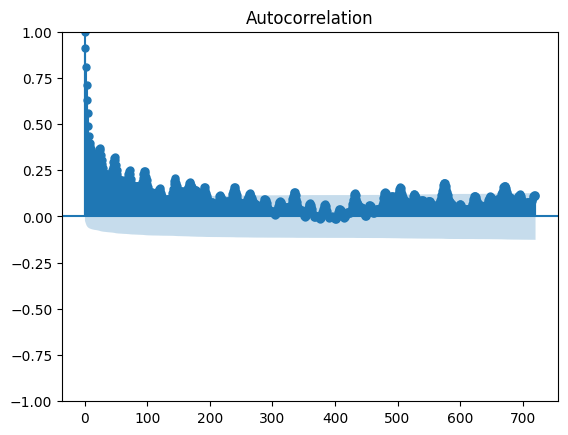

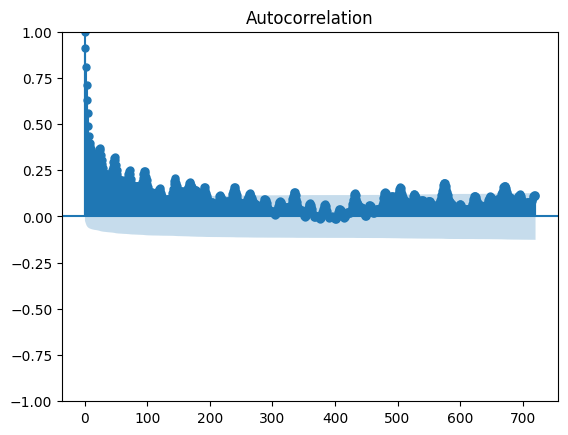

In [251]:
plot_acf(df1['y'],lags=720)

In [253]:
# from statsmodels.tsa.ar_model import AutoReg

# aic_values = []
# for lag in range(1, 3000+1):
#     model = AutoReg(df1['y'], lags=lag).fit()
#     aic_values.append(model.aic)

# best_lag = aic_values.index(min(aic_values)) + 1


In [224]:
f, Pxx = signal.welch(df1['y'], 6000, nperseg=1024)

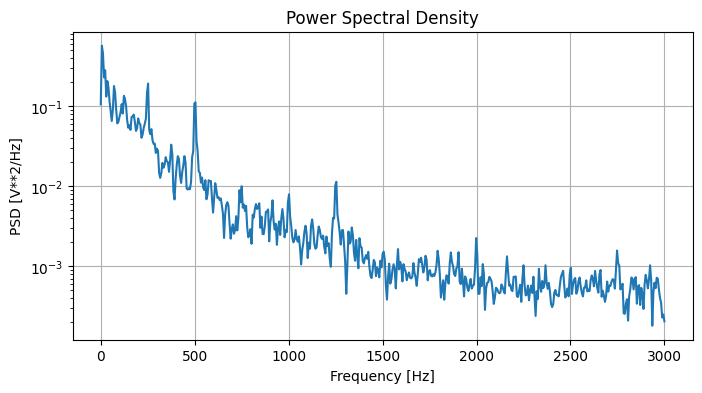

In [225]:
plt.figure(figsize=(8, 4))
plt.semilogy(f, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Power Spectral Density')
plt.grid()
plt.show()

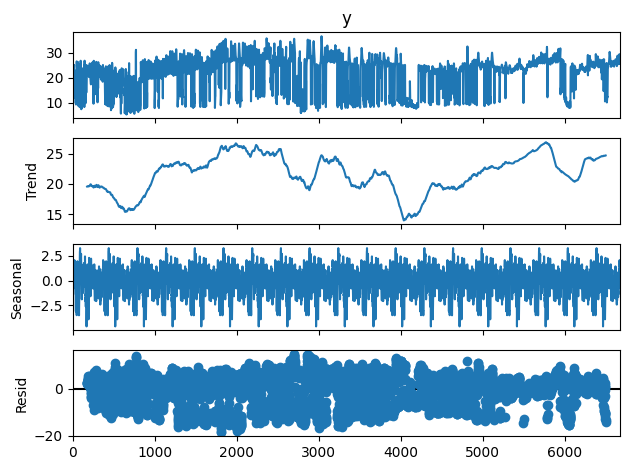

In [226]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df1['y'], model='additive', period=350)
result.plot()
plt.show()

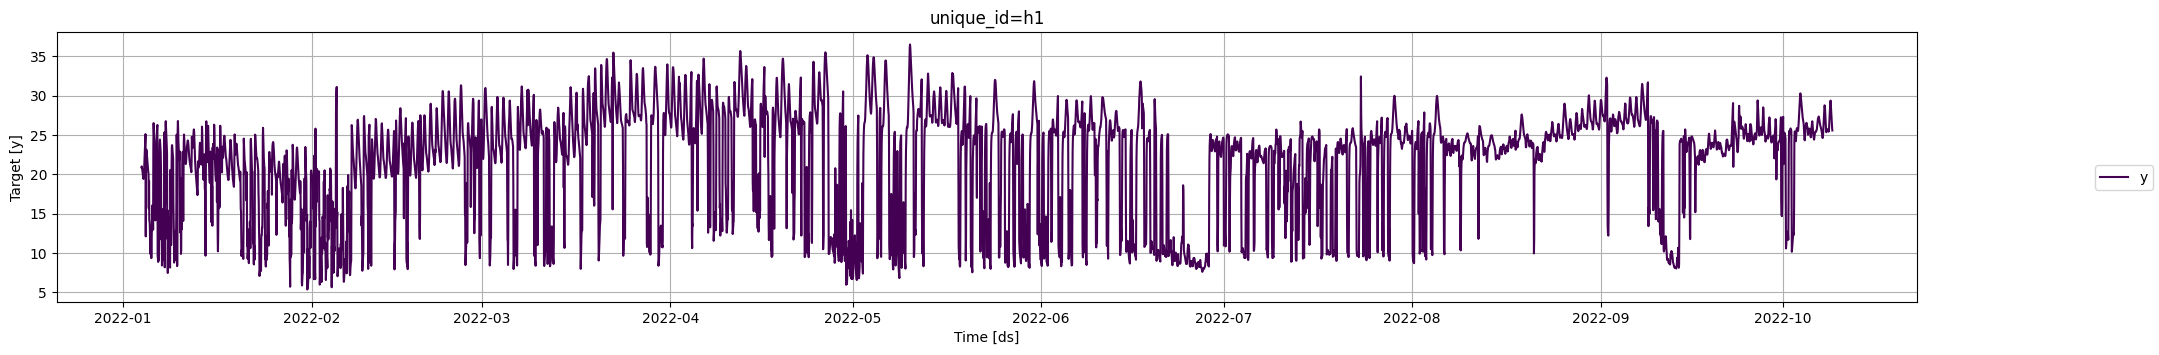

In [177]:
plot_series(df1)

In [178]:
# df1['y']=df1['y']-result.seasonal
# df1['y']=df1['y']-result.trend
# df1.dropna(inplace=True)


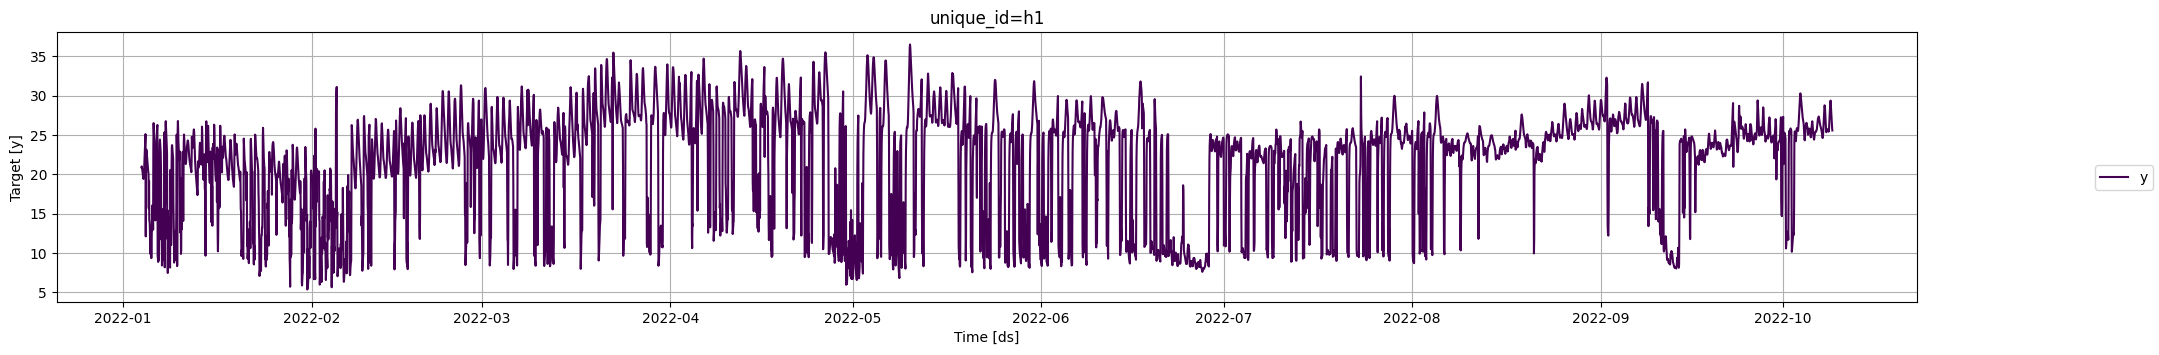

In [279]:
plot_series(df1)

In [305]:
df1['ds'] = pd.to_datetime(df1['ds'])
df1.head()

,Datetime1,unique_id,ds,y
0,0,h1,2022-01-04 00:00:00,20.867
1,1,h1,2022-01-04 01:00:00,21.000
2,2,h1,2022-01-04 02:00:00,20.867
3,3,h1,2022-01-04 03:00:00,20.650
4,4,h1,2022-01-04 04:00:00,20.400


In [306]:
train=df1[:5340]
test=df1[5340:]
train.shape,test.shape

((5340, 4), (1336, 4))

In [292]:
class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **prophet_params):
        self.prophet_params = prophet_params
        self.model = None

    def fit(self, X, y):
        df = X.copy()
        df['y'] = y
        df['ds'] = df.index
        self.model = Prophet(**self.prophet_params)
        self.model.fit(df)
        return self

    def predict(self, X):
        df = X.copy()
        df['ds'] = df.index
        return self.model.predict(df)['yhat'].values

In [293]:
model=XGBRegressor(random_state=990,learning_rate=0.01,n_estimators=1000,max_depth=20,reg_lambda=0.2)
ftsc=MLForecast(
    models={
        # 'xgb':model,
        'prophet':ProphetWrapper(),
    },
    freq='H',
    # lags=[24,168 ,350,720],
    # lag_transforms={
    #     168:[(rolling_mean,168),(rolling_std,168),(rolling_min,168),(rolling_max,168)],
    #     350:[(rolling_mean,350),(rolling_std,350),(rolling_min,350),(rolling_max,350)],
    #     720:[(rolling_mean,720),(rolling_std,720),(rolling_min,720),(rolling_max,720)]
    # },
    # target_transforms=[Differences([168,350,720])],
    # date_features=["day",'hour','weekday','month','year','dayofyear','quarter'],
)
ftsc.fit(train,id_col='unique_id',time_col='ds',target_col='y',static_features=['Datetime1'])
# min_child_weight=
# ,gamma=
# ,subsample=
# objective="reg:squarederror",

DateParseError: day is out of range for month: 0, at position 0

In [270]:
preds=ftsc.predict(1336)
preds.head()

,unique_id,ds,xgb
0,h1,2022-08-14 12:00:00,33.262582
1,h1,2022-08-14 13:00:00,41.140480
2,h1,2022-08-14 14:00:00,35.072757
3,h1,2022-08-14 15:00:00,39.307183
4,h1,2022-08-14 16:00:00,36.983017


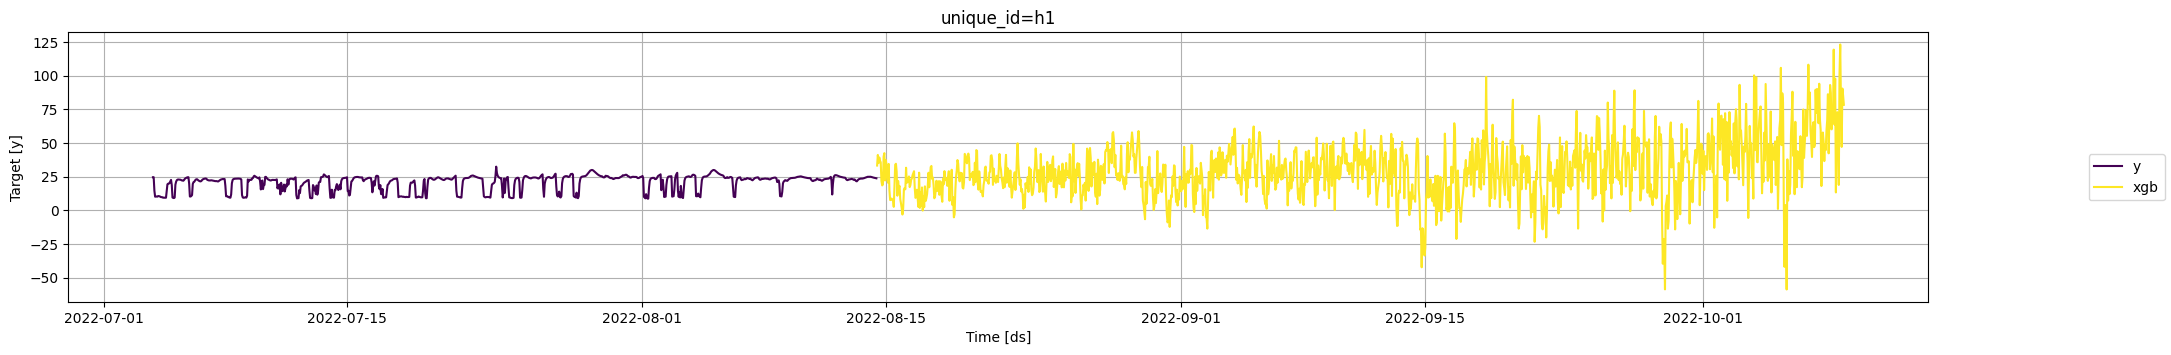

In [271]:
plot_series(train,preds,max_insample_length=1000)

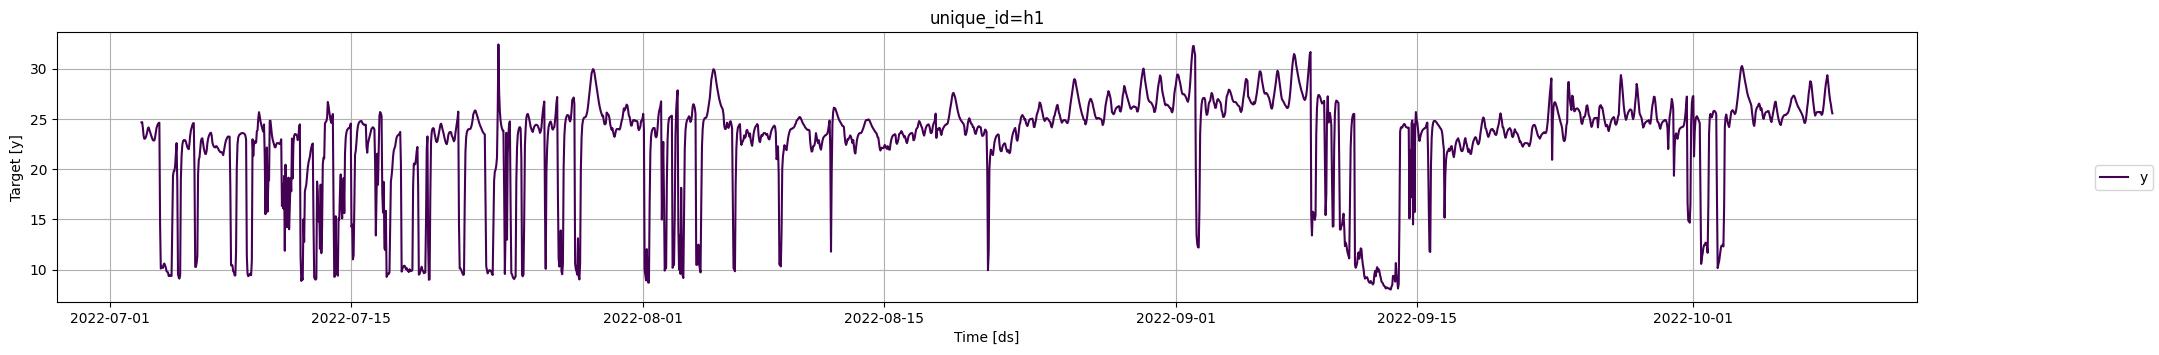

In [184]:
plot_series(df1,max_insample_length=2360)

In [185]:
# # def custom_accuracy(y_true, y_pred, threshold=0.8):
# #     return y_true - y_pred
# #     # return np.mean(np.abs((y_true - y_pred) / y_true) <= threshold)
# # custom_accuracy(test['y'].reset_index(), preds['xgb'])
# a=test['y'].reset_index()
# a

In [266]:
mse_test = mean_squared_error(test['y'], preds['xgb'])
mse_test

np.float64(520.6605590880602)

In [199]:
a=[]
for i in range(9):
    a.append(df1[i*720:(i+1)*720])

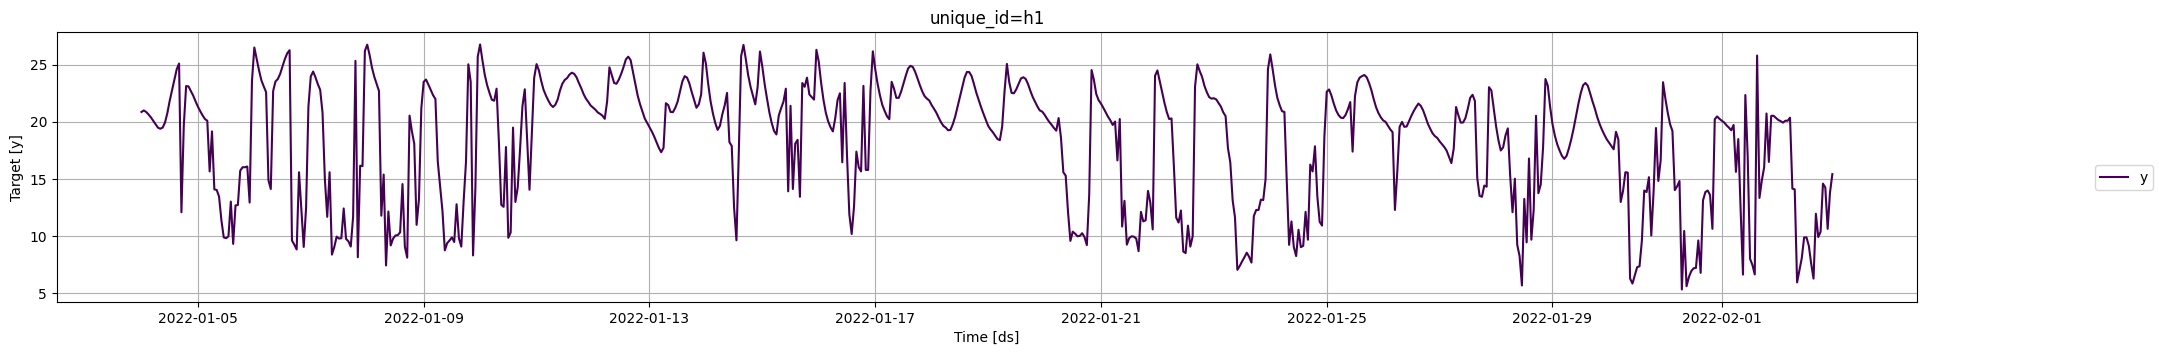

In [200]:
plot_series(a[0])

In [201]:
df1.head()

,Datetime1,unique_id,ds,y
0,0,h1,2022-01-04 00:00:00,20.867
1,1,h1,2022-01-04 01:00:00,21.000
2,2,h1,2022-01-04 02:00:00,20.867
3,3,h1,2022-01-04 03:00:00,20.650
4,4,h1,2022-01-04 04:00:00,20.400


In [222]:
f, Pxx = signal.welch(a[0]['y'],720, nperseg=1024)
sorted_arr = np.sort(Pxx)[::-1]
sorted_arr[1]
np.where(Pxx == sorted_arr[1])[0][0]

np.int64(2)

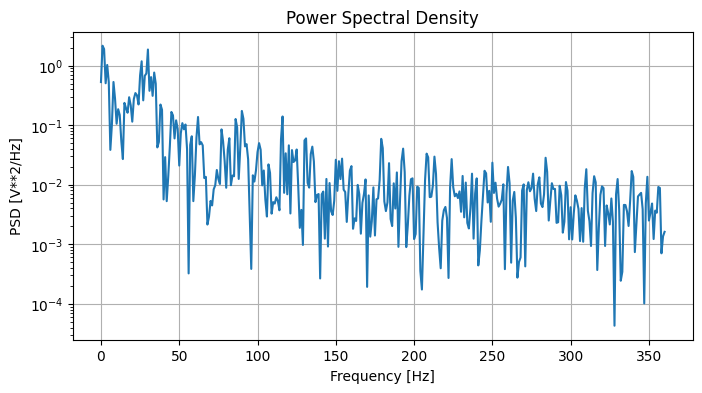

In [214]:
plt.figure(figsize=(8, 4))
plt.semilogy(f, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Power Spectral Density')
plt.grid()
plt.show()

In [202]:
a[0].shape

(720, 4)

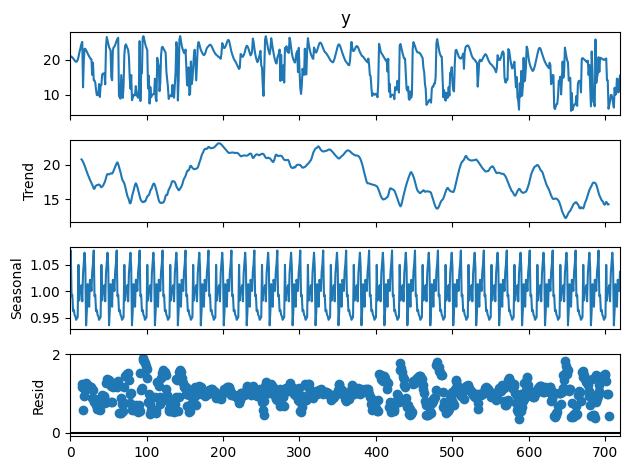

In [309]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(a[0]['y'], model='multiplicative', period=30)
result.plot()
plt.show()


In [191]:
a[0]['y']=a[0]['y']-result.seasonal
a[0]['y']=a[0]['y']-result.trend

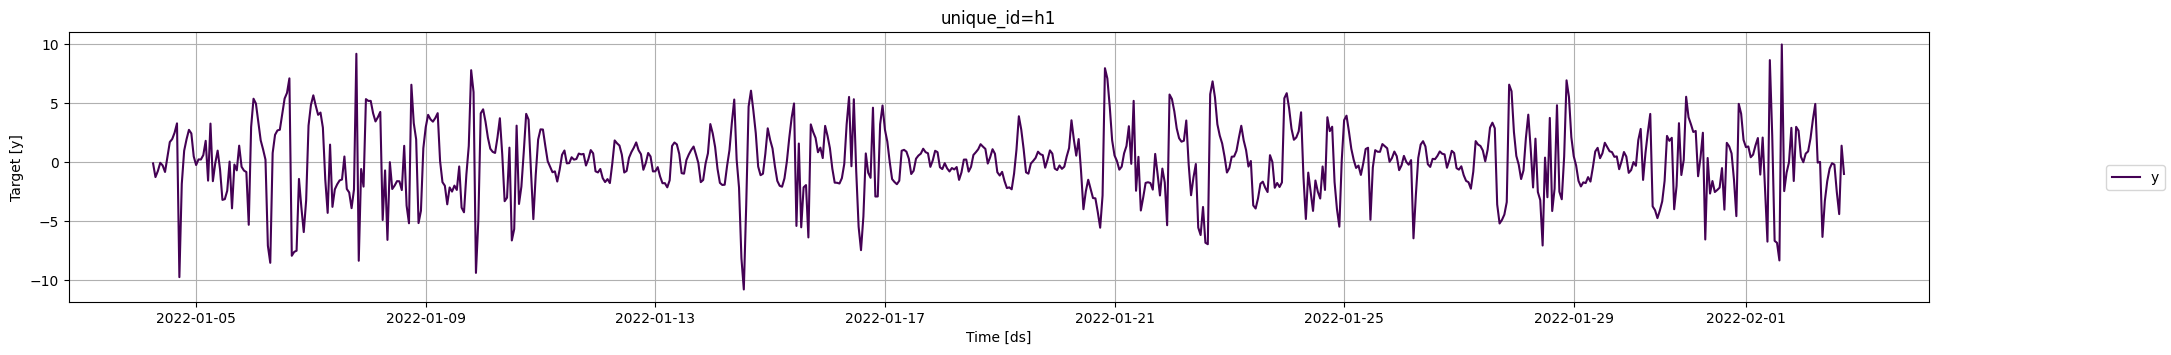

In [192]:
plot_series(a[0])

In [307]:
m=Prophet()
m.fit(train)

08:34:14 - cmdstanpy - INFO - Chain [1] start processing
08:34:15 - cmdstanpy - INFO - Chain [1] done processing


In [308]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
5700,2023-08-10 11:00:00
5701,2023-08-11 11:00:00
5702,2023-08-12 11:00:00
5703,2023-08-13 11:00:00
5704,2023-08-14 11:00:00
